In [6]:
import numpy as np
import pandas as pd
import json
import spacy
import matplotlib.pyplot as plt
import datetime

import bbcode
import string
import re

from spacy_langdetect import LanguageDetector

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer

import wordcloud

import gensim

%matplotlib inline

In [7]:
df_usable = pd.read_csv('../supercase-airplane/data/data.csv',index_col=0)

In [8]:
#preview first review
df_usable.head()

,verified,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,overall_rating,recommended,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,flight_company,airplane_model
date,,,,,,,,,,,,,,,,
2020-01-25,True,"""will never fly American again""",Greensboro to Las Vegas via Charlotte. I wil...,Business,Greensboro,Las Vegas via Charlotte,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN
2020-01-25,False,"""just comfortable enough""",Not Verified | Tokyo to Dallas. I was dreadin...,Solo Leisure,Tokyo,Dallas,January 2020,8.0,yes,3.0,4.0,4.0,4.0,4.0,american-airlines,Boeing 777-200
2020-01-24,True,"""never fly with them again""",Providence to Tucson via Chicago. American A...,Solo Leisure,Providence,Tucson via Chicago,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN
2020-01-24,False,"""Horrible customer service""",Not Verified | Philadelphia to Boston. Horrib...,Business,Philadelphia,Boston,December 2019,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN
2020-01-23,True,"""missed my connecting flight""",Houston to Dallas. I had departed from Ameri...,Solo Leisure,Houston,Dallas,January 2020,4.0,no,2.0,3.0,3.0,1.0,1.0,american-airlines,NaN


In [9]:
df_usable['review_comment'].describe()

count                                                 12235
unique                                                10392
top       Never again! Our two year old was expected to ...
freq                                                      2
Name: review_comment, dtype: object

In [10]:
#some duplicate reviews exist, but we will deal with them later.

review_lengths = [len(x.split()) for x in df_usable['review_comment']]
print(len(review_lengths)) #no of reviews
print(sum(review_lengths)/len(review_lengths)) #mean character length of a review
df_usable['review_length']=df_usable['review_comment'].map(lambda x: len(x.split()))

12235
152.05026563138537


(array([ 744., 2412., 2420., 1948., 1338.,  960.,  691.,  485.,  337.,
         257.,  163.,  134.,   93.,   66.,   49.,   36.,   33.,   33.,
          26.,   10.]),
 array([ 15. ,  48.6,  82.2, 115.8, 149.4, 183. , 216.6, 250.2, 283.8,
        317.4, 351. , 384.6, 418.2, 451.8, 485.4, 519. , 552.6, 586.2,
        619.8, 653.4, 687. ]),
 <a list of 20 Patch objects>)

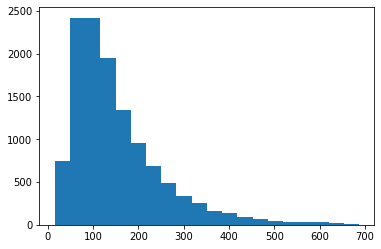

In [11]:
#plot distribution of review lengths -- longer reviews more usable

plt.hist(df_usable['review_length'],bins=20)

In [12]:
df_usable.describe()

,overall_rating,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,review_length
count,11964.000000,11971.000000,11952.000000,9746.000000,9000.000000,12233.000000,12235.000000
mean,4.327232,2.647899,2.841198,2.455674,2.364111,2.616447,152.050266
std,3.364083,1.393951,1.547902,1.503386,1.515406,1.578924,101.893428
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,81.000000
50%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,124.000000
75%,8.000000,4.000000,4.000000,4.000000,4.000000,4.000000,193.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,687.000000


In [13]:
#cut off review lengths at the 25th percentile. 
#Short reviews contain too little info, but we can't discard too much data either.

np.percentile(df_usable['review_length'],0)

15.0

In [14]:
#get data where review is longer than reviews at 25th percentile
df_ready = df_usable[df_usable['review_length']>=np.percentile(df_usable['review_length'],0)].reset_index(drop=True) #Remove very short reviews that are likely to be junk

In [15]:
print('Min length:',min(df_ready['review_length']),'words') #shortest review length. 
df_ready.head()

Min length: 15 words


,verified,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,overall_rating,recommended,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,flight_company,airplane_model,review_length
0,True,"""will never fly American again""",Greensboro to Las Vegas via Charlotte. I wil...,Business,Greensboro,Las Vegas via Charlotte,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,215
1,False,"""just comfortable enough""",Not Verified | Tokyo to Dallas. I was dreadin...,Solo Leisure,Tokyo,Dallas,January 2020,8.0,yes,3.0,4.0,4.0,4.0,4.0,american-airlines,Boeing 777-200,113
2,True,"""never fly with them again""",Providence to Tucson via Chicago. American A...,Solo Leisure,Providence,Tucson via Chicago,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,52
3,False,"""Horrible customer service""",Not Verified | Philadelphia to Boston. Horrib...,Business,Philadelphia,Boston,December 2019,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,44
4,True,"""missed my connecting flight""",Houston to Dallas. I had departed from Ameri...,Solo Leisure,Houston,Dallas,January 2020,4.0,no,2.0,3.0,3.0,1.0,1.0,american-airlines,NaN,170


In [16]:
#Check how much data remains
len(df_ready)

12235

In [17]:
#descriptive summary for filtered reviews

ready_data = df_ready.describe()

for col in ready_data:
    ready_data[col] = ready_data[col].map(lambda x: round(x,2))

ready_data

,overall_rating,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,review_length
count,11964.00,11971.00,11952.00,9746.00,9000.00,12233.00,12235.00
mean,4.33,2.65,2.84,2.46,2.36,2.62,152.05
std,3.36,1.39,1.55,1.50,1.52,1.58,101.89
min,1.00,0.00,0.00,0.00,1.00,0.00,15.00
25%,1.00,1.00,1.00,1.00,1.00,1.00,81.00
50%,3.00,3.00,3.00,2.00,2.00,2.00,124.00
75%,8.00,4.00,4.00,4.00,4.00,4.00,193.00
max,10.00,5.00,5.00,5.00,5.00,5.00,687.00


(array([ 744., 2412., 2420., 1948., 1338.,  960.,  691.,  485.,  337.,
         257.,  163.,  134.,   93.,   66.,   49.,   36.,   33.,   33.,
          26.,   10.]),
 array([ 15. ,  48.6,  82.2, 115.8, 149.4, 183. , 216.6, 250.2, 283.8,
        317.4, 351. , 384.6, 418.2, 451.8, 485.4, 519. , 552.6, 586.2,
        619.8, 653.4, 687. ]),
 <a list of 20 Patch objects>)

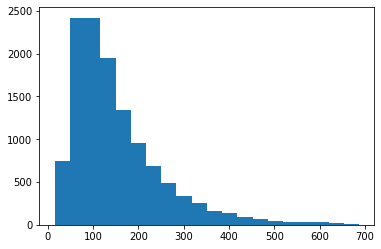

In [18]:
#Dropped more than half the total dataset, but remaining reviews should be highly usable.

plt.hist(df_ready['review_length'],bins=20)

In [19]:
#preview 1 review
df_ready.iloc[0,7] #Most reviews are between 4 and 200 words long.

1.0

In [20]:
#summarise the new df
df_ready['review_comment'].describe()

count                                                 12235
unique                                                10392
top       Never again! Our two year old was expected to ...
freq                                                      2
Name: review_comment, dtype: object

In [21]:
#What are the 10 most duplicated reviews?
#Steam reviews tend to be spammy 
df_ready['review_comment'].value_counts()[:10] 

Never again! Our two year old was expected to sit over 7 aisles away from any of the adults in our party. Due to boarding staff the queue at the gate was disrupted this resulted in our party being placed further along the queue to board (we had been near the front). When we finally got on board there were only odd seats dotted around the aircraft. None of the adults could be seated together which was not such a major issue but the Ryanair flight attendants (there for safety not service) thought it perfectly ok to seat a two year old 7 aisles from the nearest adult in our party. A two year old cannot understand or comprehend any safety procedure and Ryanair do not even accept unaccompanied minors.                                                                                                                                                                                                                                                                                                       

### Review Spam/Ham Problem
- Some reviews have been spammed multiple times, or just happen to come out the same.
- All reviewers' opinions are important, but repeated reviews sometimes originate from one player. 
- Removing duplicates controls the "vocal minority" problem effectively.
- Need to clean away any text that is not strictly English. It is possible for text from other languages to be wrongly labelled as English. (Reviews scraped were all labelled as being in English)

In [22]:
#drop duplicate entries in reviews, because they are considered spam
df_cleaning = df_ready.drop_duplicates(subset=['review_comment'])

In [23]:
df_cleaning.select_dtypes(include='O').describe()

,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,recommended,flight_company,airplane_model
count,10392,10392,7863,7857,7857,10392,10392,10392,3827
unique,6791,10392,4,980,2170,67,2,4,443
top,British Airways customer review,Return flight from LHR T5 to Washington Dulles...,Solo Leisure,London,London,May 2015,no,american-airlines,A380
freq,954,1,2545,450,330,1435,6639,3527,590


In [24]:
deduplicated_rows = abs(len(df_cleaning) - len(df_ready)) #find out how many rows were removed during deduplication
print(deduplicated_rows)
print(deduplicated_rows/len(df_ready)) #Percentage of data that was duplicated

1843
0.15063342868818963


### De-Duplication

Rigorous as our check was, no rows were dropped just because the text was exactly the same.

It appears that a hanadful of unique reviewers have written the same review by random chance, or some players use multiple accounts to post the same text.

# Language Cleaning

Just to be absolutely sure all text is in English, we will do language detection. 

Exploration of another dataset turned up Chinese and Portuguese text, so this step was deemed necessary.

In [25]:
8150-5045

3105

In [26]:
#get languages by document
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
    
def get_lang_doc(text): #gets average language probability scores and returns highest-ranked language
    doc = nlp(text)
    return doc._.language['language']

#count languages for sentences in document
def get_langs_sent(text):
    langs={}
    lang_st={}
    doc = nlp(text)
    
    for i, sent in enumerate(doc.sents):
        langs[i]=sent._.language['language'] #Iterating through sentence level, thus only need to add language. Probability scores should be quite high per sentence.
    
    lang_st = list(set(langs.values())) #Get language code of each language that appeared. As long as more than 1 language appears, the review will be excluded.
    
    return lang_st

In [27]:
#test the language detection function

dc=df_cleaning['review_comment'][np.random.randint(0,len(df_cleaning['review_comment']))]
doc=nlp(dc)
print(dc+'\n-----')
print(doc._.language)

 I would like to share the horrible experience that I had flying with American Airlines. I bought tickets from them to travel from Toronto to Houston and return. Toronto to Chicago to Houston (01/24/2018) Houston to Dallas to Toronto (01/29/18) The flight from Toronto to Houston was ok except for an hour delay. Everything turned into a nightmare when we were travelling back from Houston. Our flight from Houston was at 4:20PM (45 mins flight to Dallas) and our connecting flight from Dallas to Toronto was at 6:25PM (2hr 25 mins to Toronto). We got on the flight at 4:20 and we were stuck there for almost 1.5 hrs. According to the captain the air control did not give clearance and the plane had to refuel since it did not plan for the delay. After 1.5 hours they informed that we will not be able to catch our connecting flight from Dallas so it’s better to get off and re-book from Houston. We got off and asked to get our checked-in luggage. They said they cannot take that out and it will be 

In [29]:
for i in range(3):
    random_select = np.random.randint(0,len(df_cleaning['review_comment']))
    print(random_select)
    print(df_cleaning['review_comment'][random_select])
    langs = get_langs_sent(df_cleaning['review_comment'][random_select])
    print(langs)
    print()

2695
Overall an interesting travel experience with American Airlines. First time with them on medium haul across the Atlantic. Amazing IFE on-board the Boeing 777 for this flight from London to New York JFK. Food options limited and if you are a vegetarian, there is only an option for a vegan meal. Space and toilets satisfactory. Terminal 3 at Heathrow busy and long queues. Seat to seat calls are available besides WIFI access onboard with a minimal charge of course. Overall good and may fly with them again.
['en']

5190
  Oslo to London Heathrow. Check in was chaotic, and ground staff had no idea about check in, no information about lounge access, transfer etc. I'm emerald frequent flyer with British Airways. Seat is usual economy seat, it's a joke they sell this product as business class. No entertainment and a disgraceful meal on business class. Service was very fast. Overall experience in this flight was no any better than economy class - it's a complete joke they call this product 

In [30]:
#test langdetect by sentence
random_select = np.random.randint(0,len(df_cleaning['review_comment']))
print(random_select)
print(df_cleaning['review_comment'][random_select])
get_langs_sent(df_cleaning['review_comment'][random_select])

4142
  BA Lounge in Toronto Pearson closed last year. The new First/Gold lounge is dated, rammed, only one shower which was like being in a old, poorly run gym. Poor food selection and nobody in the lounge was eating. Overnight flight time to LHR was 6:15. Tiny welcome drink took 20 minutes to arrive. Waited an hour after take off to receive another drink. Service took just over 2 hours once in the air. No sense of urgency by crew to think that passengers may wish to get more than 2 hours sleep. Skeleton-staff of crew working a large business class cabin, embarrassing serving of nuts with drink. Warm wine. Cheap meat on menu, watery soup, no bread basket etc. Wake me up card requests ignored as woken up by 40 mins to landing announcement. Given up complaining/feeding back to BA, knowing that I'll receive a 'cut and paste' response. Functional business class for the bed/space only - set your expectations low and you'll step off a BA flight with a spring in your step.


['en']

In [31]:
#get languages by document for the same review

test_review = df_cleaning['review_comment'][2160]
get_lang_doc(test_review)

'en'

In [32]:
#In most cases, only English will be detected. Sometimes, get_langs_sent throw false positives like in the above examples.
#Also heavy on operations; slows computation down.
#Trying doc langs instead.

trial_doc_langs = df_cleaning['review_comment'][:5].map(lambda x: get_lang_doc(x))

In [33]:
trial_doc_langs

0    en
1    en
2    en
3    en
4    en
Name: review_comment, dtype: object

In [34]:
#doc_langs will be used from here on. 
#Some risk of losing data due to bits of foreign language text, but acceptable if it does not drop too much data.

doc_langs = [get_lang_doc(x) for x in df_cleaning['review_comment']] #WARNING: SLOW! May take a couple of minutes to finish.

In [36]:
df_cleaning['review_lang']=doc_langs

C:\Users\Mancef\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_cleaning.head()

,verified,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,overall_rating,recommended,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,flight_company,airplane_model,review_length,review_lang
0,True,"""will never fly American again""",Greensboro to Las Vegas via Charlotte. I wil...,Business,Greensboro,Las Vegas via Charlotte,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,215,en
1,False,"""just comfortable enough""",Not Verified | Tokyo to Dallas. I was dreadin...,Solo Leisure,Tokyo,Dallas,January 2020,8.0,yes,3.0,4.0,4.0,4.0,4.0,american-airlines,Boeing 777-200,113,en
2,True,"""never fly with them again""",Providence to Tucson via Chicago. American A...,Solo Leisure,Providence,Tucson via Chicago,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,52,en
3,False,"""Horrible customer service""",Not Verified | Philadelphia to Boston. Horrib...,Business,Philadelphia,Boston,December 2019,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,44,en
4,True,"""missed my connecting flight""",Houston to Dallas. I had departed from Ameri...,Solo Leisure,Houston,Dallas,January 2020,4.0,no,2.0,3.0,3.0,1.0,1.0,american-airlines,NaN,170,en


In [39]:
df_langs_cleaned = df_cleaning[df_cleaning['review_lang']=='en'].reset_index(drop=True)
len(df_langs_cleaned)

10388

In [40]:
mult_ln_reviews_dropped = (len(df_cleaning) - len(df_langs_cleaned))/len(df_cleaning)
print(mult_ln_reviews_dropped)

0.00038491147036181676


In [43]:
df_cleaning.to_csv('../supercase-airplane/data/data_cleaning.csv') #saving so I don't have to run the cleaning operation again

### Dropped multi-lingual reviews

~18% of the usable reviews were dropped because more than 1 language was detected. 

This is acceptable loss of data even in the event of false positives. (Also, fewer false positives than going by sentences in each document)

We want to reduce the number of multilingual reviews so non-English text will become infrequently-occurring in the dataset.

This will make it easier for filtering functions to eliminate them, preventing them from producing noise in our data model.

### Text cleaning

Steam reviews use BBCode, a form of markup language used to format bulletin board posts (hence the name). 

Regex can be used to clean this out, but there is a pre-built package for this exact purpose.

No need to reinvent the wheel.

In [45]:
final_df = pd.read_csv('../supercase-airplane/data/data_cleaning.csv',index_col=0)

In [46]:
final_df["review_comment"].head()

0      Greensboro to Las Vegas via Charlotte. I wil...
1    Not Verified |  Tokyo to Dallas. I was dreadin...
2      Providence to Tucson via Chicago. American A...
3    Not Verified |  Philadelphia to Boston. Horrib...
4      Houston to Dallas. I had departed from Ameri...
Name: review_comment, dtype: object

In [47]:
final_df['review_comment'] = final_df['review_comment'].map(lambda x: ''.join(c for c in x if c not in string.punctuation).split()) 
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again

In [48]:
final_df.head()

,verified,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,overall_rating,recommended,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,flight_company,airplane_model,review_length,review_lang
0,True,"""will never fly American again""","[Greensboro, to, Las, Vegas, via, Charlotte, I...",Business,Greensboro,Las Vegas via Charlotte,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,215,en
1,False,"""just comfortable enough""","[Not, Verified, Tokyo, to, Dallas, I, was, dre...",Solo Leisure,Tokyo,Dallas,January 2020,8.0,yes,3.0,4.0,4.0,4.0,4.0,american-airlines,Boeing 777-200,113,en
2,True,"""never fly with them again""","[Providence, to, Tucson, via, Chicago, America...",Solo Leisure,Providence,Tucson via Chicago,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,52,en
3,False,"""Horrible customer service""","[Not, Verified, Philadelphia, to, Boston, Horr...",Business,Philadelphia,Boston,December 2019,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,44,en
4,True,"""missed my connecting flight""","[Houston, to, Dallas, I, had, departed, from, ...",Solo Leisure,Houston,Dallas,January 2020,4.0,no,2.0,3.0,3.0,1.0,1.0,american-airlines,NaN,170,en


In [49]:
#Time to explore the corpus word frequency.
#Get all words in the corpus

word_lst = []
for i in final_df['review_comment']:
    word_lst.extend(i)
    
cleaned_words = word_lst

print(len(word_lst))

1614111


In [50]:
#100 most common words in the corpus
wordfreq = nltk.FreqDist(word_lst)
# Print the most common words.
print(wordfreq.most_common(100))

[('the', 67233), ('to', 60170), ('and', 47814), ('I', 33517), ('was', 33150), ('a', 32262), ('in', 21457), ('of', 21086), ('on', 19575), ('flight', 19051), ('for', 18107), ('with', 16039), ('that', 13054), ('were', 12845), ('not', 11820), ('my', 11736), ('is', 11695), ('The', 11120), ('we', 11040), ('at', 10871), ('it', 10262), ('had', 10124), ('they', 9778), ('have', 9479), ('but', 9057), ('from', 9033), ('this', 7944), ('as', 7552), ('be', 6718), ('service', 6643), ('me', 6589), ('you', 6481), ('time', 6407), ('no', 6303), ('very', 5879), ('our', 5683), ('an', 5675), ('are', 5442), ('so', 5305), ('seat', 4652), ('all', 4592), ('would', 4526), ('seats', 4501), ('get', 4388), ('which', 4369), ('We', 4324), ('us', 4313), ('crew', 4216), ('there', 4081), ('American', 4069), ('one', 4004), ('their', 3977), ('or', 3955), ('plane', 3925), ('BA', 3925), ('by', 3900), ('good', 3891), ('out', 3867), ('airline', 3759), ('staff', 3756), ('food', 3676), ('only', 3670), ('flights', 3632), ('hours'

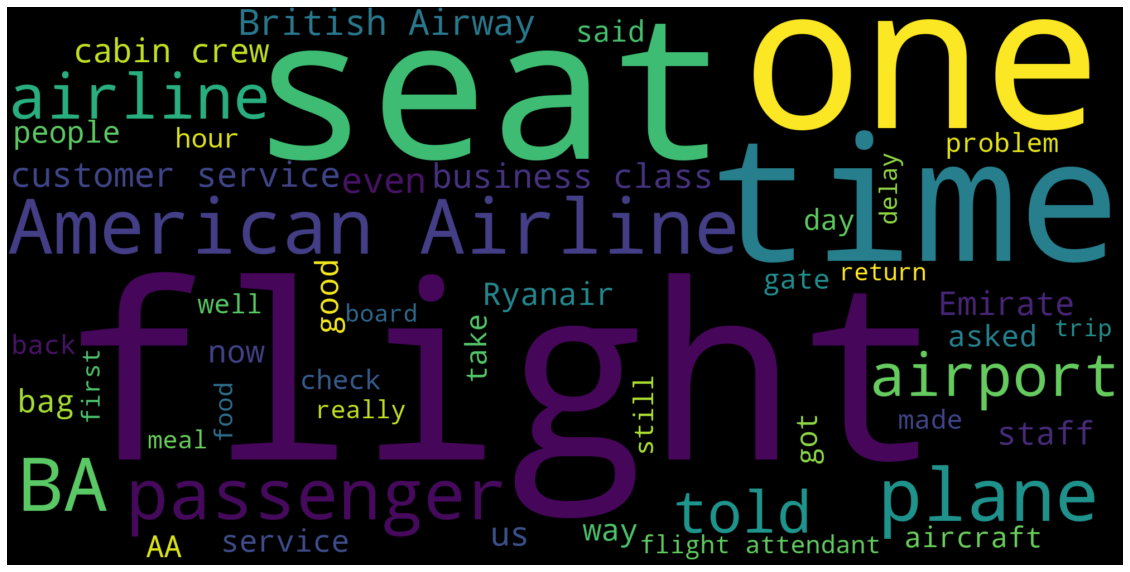

In [51]:
#turn the word list into a str for wordcloud generation
text = ' '.join(w for w in word_lst)

# Create and generate a word cloud image:
wcd = wordcloud.WordCloud(width = 2000, height=1000, max_words = 50).generate(text)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

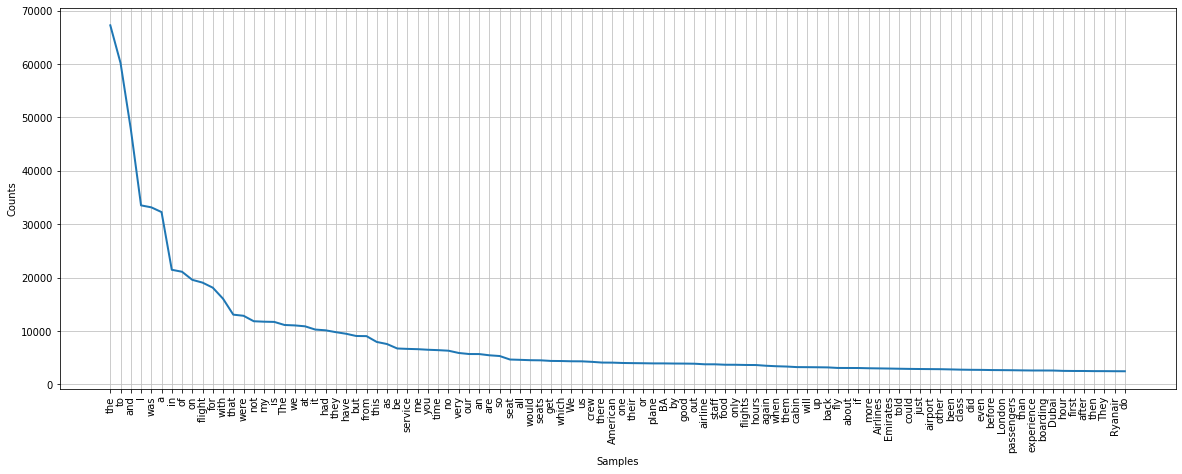

In [53]:
plt.figure(figsize=(20,7))
wordfreq.plot(100,cumulative=False)

# First Word Cloud

1st Word Cloud does not seem very coherent. 

Perhaps creating phrases (n-grams) will increase coherence.

In [54]:
# Credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this code

# Build the bigram and trigram models
bigram = gensim.models.Phrases(list(final_df['review_comment']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to train generator model]
trigram = gensim.models.Phrases(bigram[list(final_df['review_comment'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Word Frequencies

While it can be seen that the stopwords made the word clouds have clearer terms, we will take a step back and make n-grams before we remove stopwords and numbers, and lemmatise text.

This is just in case any of these words form part of an n-gram that may prove crucial to more accurate analysis later.

In [55]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [56]:
def lemma(bow):
    
    #Use SpaCy lemmatiser to lemmatise words.
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ for token in lemma_doc if token.lemma_ != '-PRON-']    #ignore n-grams and pronouns
    
    return lemma_text

In [57]:
def stop_lemma(text):
    text = remove_stopwords(text)
    text = lemma(text)
    return text

#remove newly-added stopwords from clean reviews only after getting bigrams and trigrams just in case those stopwords happen to be part of any n-grams.
#After that, lemmatise.
#Any remaining numbers can be removed at this point, as they are unlikely to be part of any helpful terms.

In [58]:
#testing bigram function
t = [['three', 'kingdoms', 'period'],['romance', 'three', 'kingdoms'],['three', 'kingdoms', 'strategy'],['romance', 'three', 'kingdoms'],
     ['romance','three', 'kingdoms'],['three', 'kingdoms', 'strategy'],['total_war','three', 'kingdoms'],['3', 'kingdoms', 'period'],['three','kingdoms']]

print(make_bigrams(t))

[['three', 'kingdoms', 'period'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['romance', 'three', 'kingdoms'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['total_war', 'three', 'kingdoms'], ['3', 'kingdoms', 'period'], ['three', 'kingdoms']]


In [59]:
print(make_trigrams(t))

[['three', 'kingdoms', 'period'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['romance', 'three', 'kingdoms'], ['romance', 'three', 'kingdoms'], ['three', 'kingdoms', 'strategy'], ['total_war', 'three', 'kingdoms'], ['3', 'kingdoms', 'period'], ['three', 'kingdoms']]


In [60]:
#turning numbers into words was a good idea.
#3grams seem more coherent in general.
#consider adding more stopwords to be cleaned out of the corpus

en_stopwords.extend(['one','two','three']) #removing numbers after making n-grams should reduce noise. 

In [61]:
final_df.head()

,verified,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,overall_rating,recommended,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,flight_company,airplane_model,review_length,review_lang
0,True,"""will never fly American again""","[Greensboro, to, Las, Vegas, via, Charlotte, I...",Business,Greensboro,Las Vegas via Charlotte,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,215,en
1,False,"""just comfortable enough""","[Not, Verified, Tokyo, to, Dallas, I, was, dre...",Solo Leisure,Tokyo,Dallas,January 2020,8.0,yes,3.0,4.0,4.0,4.0,4.0,american-airlines,Boeing 777-200,113,en
2,True,"""never fly with them again""","[Providence, to, Tucson, via, Chicago, America...",Solo Leisure,Providence,Tucson via Chicago,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,52,en
3,False,"""Horrible customer service""","[Not, Verified, Philadelphia, to, Boston, Horr...",Business,Philadelphia,Boston,December 2019,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,44,en
4,True,"""missed my connecting flight""","[Houston, to, Dallas, I, had, departed, from, ...",Solo Leisure,Houston,Dallas,January 2020,4.0,no,2.0,3.0,3.0,1.0,1.0,american-airlines,NaN,170,en


In [63]:
final_df['2gram_reviews'] = make_bigrams(final_df['review_comment'])

In [64]:
final_df['3gram_reviews'] = make_trigrams(final_df['review_comment'])

In [65]:
final_df['2gram_reviews'] = final_df['2gram_reviews'].map(lambda x: stop_lemma(x))
final_df['3gram_reviews'] = final_df['3gram_reviews'].map(lambda x: stop_lemma(x))

In [66]:
final_df.head(2)

,verified,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,overall_rating,recommended,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,flight_company,airplane_model,review_length,review_lang,2gram_reviews,3gram_reviews
0,True,"""will never fly American again""","[Greensboro, to, Las, Vegas, via, Charlotte, I...",Business,Greensboro,Las Vegas via Charlotte,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,215,en,"[Greensboro, Las_Vegas, via_Charlotte, will_ne...","[Greensboro, Las_Vegas_via_Charlotte, I_will_n..."
1,False,"""just comfortable enough""","[Not, Verified, Tokyo, to, Dallas, I, was, dre...",Solo Leisure,Tokyo,Dallas,January 2020,8.0,yes,3.0,4.0,4.0,4.0,4.0,american-airlines,Boeing 777-200,113,en,"[Not_Verified, Tokyo, Dallas, dread, flight, b...","[Not_Verified, Tokyo, Dallas, dread, flight, b..."


In [67]:
#check if this cell still has pronoun tag from lemmatising "im" into '-PRON-' and "be", separating the pronoun and verb
final_df['3gram_reviews'][18]

['Not_Verified',
 'Charleston',
 'Washington',
 'This_is',
 'time',
 'time',
 'worst_airline',
 'I_have_ever',
 'Not_only',
 'staff',
 'extremely',
 'disrespectful',
 'plane',
 'late',
 'every_time',
 'for',
 'past',
 '7',
 'flight',
 'unwillingly',
 'take',
 'American',
 'has_been_delayed',
 'unprofessional',
 'punctual',
 'unaccommodating',
 'The_only_positive',
 'thing_about',
 'American_Airlines',
 'cheap',
 'do_not',
 'recommend_this_airline']

In [68]:
final_df.to_csv('../supercase-airplane/data/data_final.csv')

In [69]:
word_lst_2gram = []
for i in final_df['2gram_reviews']:
    word_lst_2gram.extend(i)
    
word_lst_3gram = []
for i in final_df['3gram_reviews']:
    word_lst_3gram.extend(i)

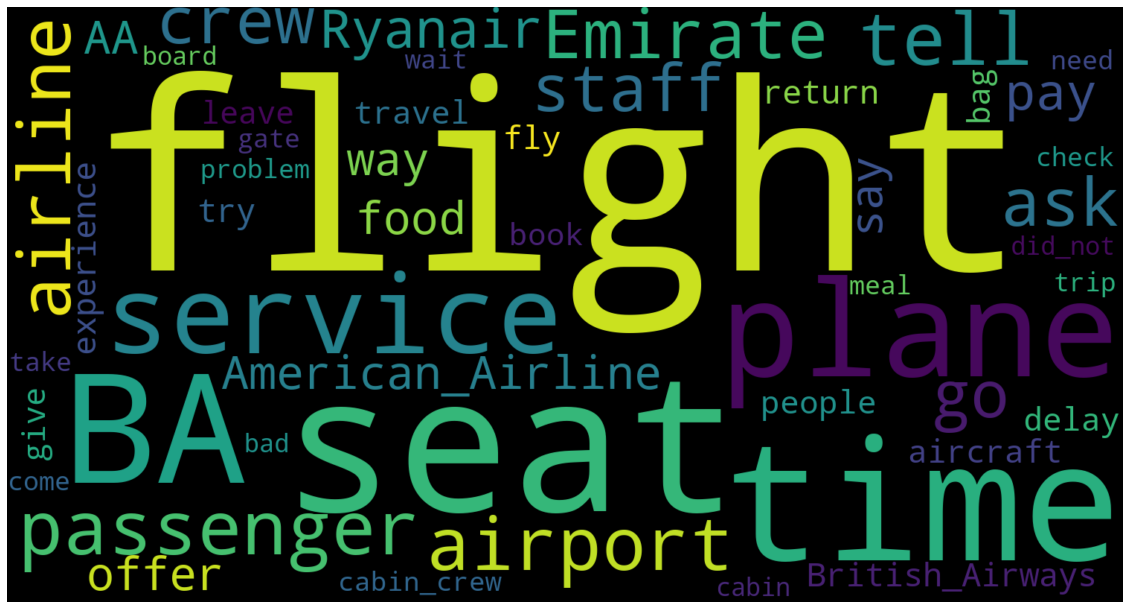

In [70]:
#generate wordcloud for 2grams
text_2grams = ' '.join(w for w in word_lst_2gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_2grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

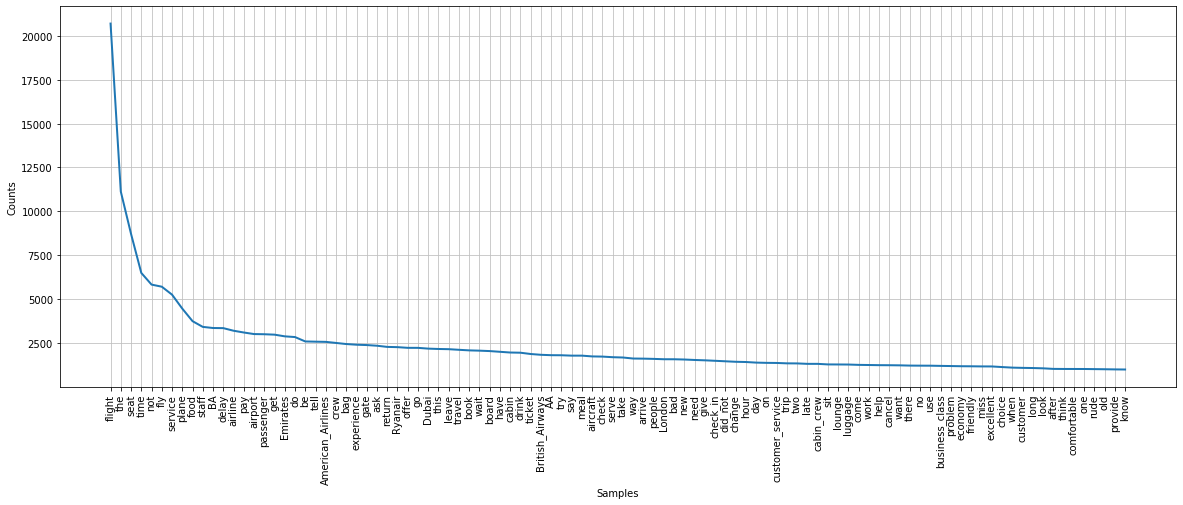

In [71]:
wordfreq_2gram = nltk.FreqDist(word_lst_2gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_2gram.plot(100,cumulative=False)

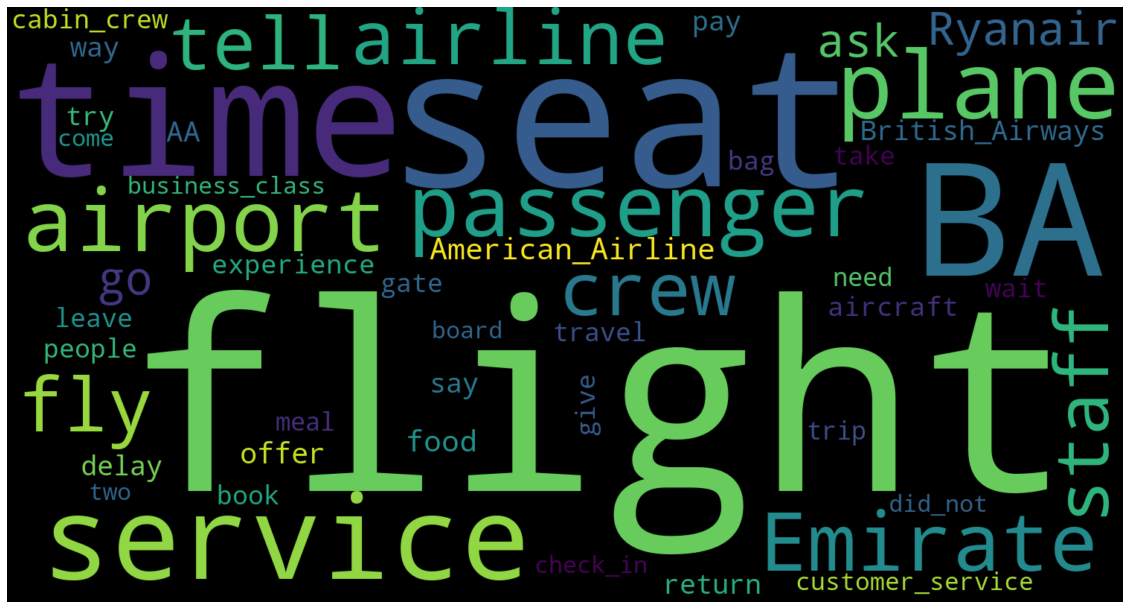

In [72]:
#generate wordcloud for 3grams
text_3grams = ' '.join(w for w in word_lst_3gram)

# Create and generate a word cloud image
wcd = wordcloud.WordCloud(width = 1500, height=800, max_words = 50).generate(text_3grams)

# Display the generated image:
plt.figure(figsize=(20,15))
plt.imshow(wcd, interpolation='bilinear')
plt.axis("off")
plt.show()

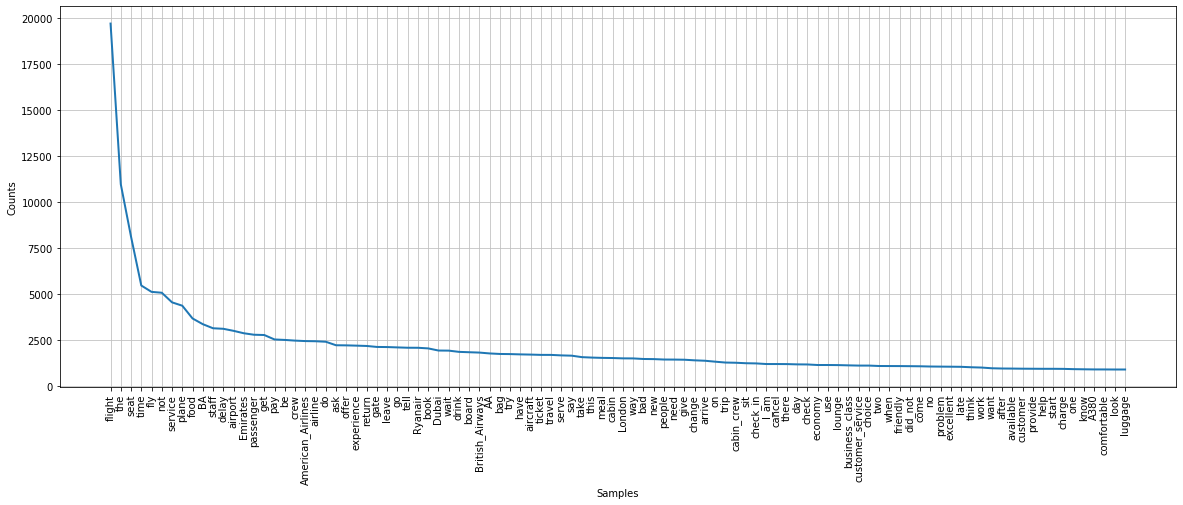

In [73]:
wordfreq_3gram = nltk.FreqDist(word_lst_3gram)
# Print the most common words.
plt.figure(figsize=(20,7))
wordfreq_3gram.plot(100,cumulative=False)

### N-grams may make topics more coherent

Coherent n-grams such as 'best_total_war' have appeared. 

Gameplay features such as 'romance_mode' (the less historically-authentic version based on the novel Romance of the Three Kingdoms) have appeared as n-gram terms.

**Next steps:**
- Try LDA first and if topics are coherent. 
    - If not, further cleaning may be needed.  
    - It may reduce noise if we remove terms that appear across multiple topics.
- 3grams seem to be most coherent, so we will use 3grams for LDA.

# References

Steamreviews https://github.com/woctezuma/download-steam-reviews/tree/master/steamreviews

Language detection package from Google: https://pypi.org/project/langdetect/

n-gram maker https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/